<a href="https://colab.research.google.com/github/Nawa-Punabantu/Opt_Algos/blob/main/Constrained_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.stats import norm


In [2]:

# ----------------------------
# 1. Define objective and constraint functions
# ----------------------------
def true_objective(x):
    return np.sin(3 * x) + 0.5 * x

def true_constraint(x):
    return 0.5 * np.cos(5 * x) - 0.25  # c(x) <= 0 is feasible region

# ----------------------------
# 2. Generate training data
# ----------------------------
np.random.seed(42)
X_train = np.random.uniform(0, 2, 10).reshape(-1, 1)
y_train_obj = true_objective(X_train).ravel()
y_train_con = true_constraint(X_train).ravel()

# ----------------------------
# 3. Fit surrogate GPs
# ----------------------------
kernel = C(1.0) * Matern(length_scale=0.5, nu=2.5) + WhiteKernel()

gp_obj = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp_con = GaussianProcessRegressor(kernel=kernel, normalize_y=True)

gp_obj.fit(X_train, y_train_obj)
gp_con.fit(X_train, y_train_con)

# ----------------------------
# 4. Define EIC function
# ----------------------------
def expected_constrained_improvement(x, surrogate_obj_gp, constraint_gps, constraint_thresholds, y_best, xi=0.01):
    x = np.asarray(x).reshape(1, -1)
    mu_obj, sigma_obj = surrogate_obj_gp.predict(x, return_std=True)

    with np.errstate(divide='warn'):
        Z = (y_best - mu_obj - xi) / sigma_obj
        ei = (y_best - mu_obj - xi) * norm.cdf(Z) + sigma_obj * norm.pdf(Z)
        ei[sigma_obj == 0.0] = 0.0

    prob_feas = 1.0
    for gp_c, lam in zip(constraint_gps, constraint_thresholds):
        mu_c, sigma_c = gp_c.predict(x, return_std=True)

        pf = norm.cdf((lam - mu_c) / sigma_c)

        pf[sigma_c == 0.0] = 0.0
        prob_feas *= pf

    eic = ei * prob_feas
    return -eic[0]


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [3]:

# ----------------------------
# 5. Evaluate EIC over grid
# ----------------------------
X_grid = np.linspace(0, 2, 200).reshape(-1, 1)
mu_obj, sigma_obj = gp_obj.predict(X_grid, return_std=True)
mu_con, sigma_con = gp_con.predict(X_grid, return_std=True)

ei_vals = []
pf_vals = []
eic_vals = []

# Best feasible objective value seen so far
feasible_idx = np.where(y_train_con <= 0)[0]
y_best_feasible = np.min(y_train_obj[feasible_idx]) if len(feasible_idx) > 0 else np.min(y_train_obj)

for x in X_grid:
    ei = expected_constrained_improvement(x, gp_obj, [gp_con], [0], y_best_feasible, xi=0.01)
    pf = norm.cdf((0 - gp_con.predict([[x[0]]], return_std=True)[0]) / gp_con.predict([[x[0]]], return_std=True)[1])

    eic_vals.append(-ei)
    pf_vals.append(pf)

    # Approximate EI (without PF) for comparison
    z = (y_best_feasible - gp_obj.predict([[x[0]]])[0] - 0.01) / gp_obj.predict([[x[0]]], return_std=True)[1]
    ei_approx = (y_best_feasible - gp_obj.predict([[x[0]]])[0] - 0.01) * norm.cdf(z) + gp_obj.predict([[x[0]]], return_std=True)[1] * norm.pdf(z)
    ei_vals.append(ei_approx)


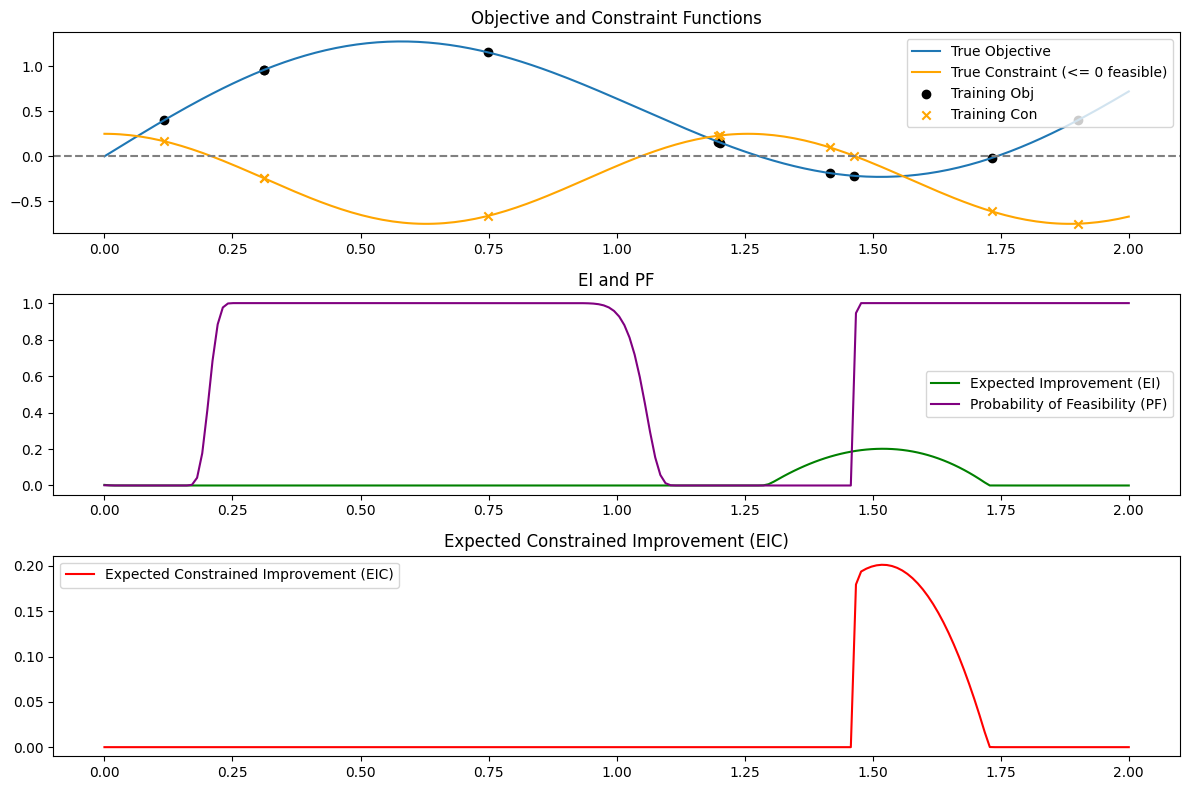

In [4]:

# ----------------------------
# 6. Plot everything
# ----------------------------
plt.figure(figsize=(12, 8))

# Plot true functions
plt.subplot(3, 1, 1)
plt.plot(X_grid, true_objective(X_grid), label='True Objective')
plt.plot(X_grid, true_constraint(X_grid), label='True Constraint (<= 0 feasible)', color='orange')
plt.axhline(0, linestyle='--', color='gray')
plt.scatter(X_train, y_train_obj, label='Training Obj', color='black')
plt.scatter(X_train, y_train_con, label='Training Con', color='orange', marker='x')
plt.title('Objective and Constraint Functions')
plt.legend()

# EI and PF
plt.subplot(3, 1, 2)
plt.plot(X_grid, ei_vals, label='Expected Improvement (EI)', color='green')
plt.plot(X_grid, pf_vals, label='Probability of Feasibility (PF)', color='purple')
plt.title('EI and PF')
plt.legend()

# EIC
plt.subplot(3, 1, 3)
plt.plot(X_grid, eic_vals, label='Expected Constrained Improvement (EIC)', color='red')
plt.title('Expected Constrained Improvement (EIC)')
plt.legend()

plt.tight_layout()
plt.show()
